# Part 1 : Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!pip install transformers
!pip install pytorch_wrapper
!pip install seaborn
!nvidia-smi

from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/fake.txt fake.txt
!cp /content/drive/MyDrive/non_fake.txt non_fake.txt
!git clone https://github.com/nlpaueb/greek-bert.git

Fri Nov  5 05:17:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
import datetime
import os
import random
import time
import unicodedata

import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import pytorch_wrapper.functional as pwF
import sklearn
import seaborn


plt.rcParams['figure.figsize'] = [20, 5]

print("Seaborn version: %s" % (seaborn.__version__))
print("Sklearn version: %s" % (sklearn.__version__))
print("Transformers version: %s" % (transformers.__version__))
print("PyTorch version: %s" % (torch.__version__))
print("Matplotlib version: %s" % (matplotlib.__version__))
print("NumPy version: %s" % (np.__version__))
print("Pandas version: %s" % (pd.__version__))

Seaborn version: 0.11.2
Sklearn version: 0.22.2.post1
Transformers version: 4.12.3
PyTorch version: 1.9.0+cu111
Matplotlib version: 3.2.2
NumPy version: 1.19.5
Pandas version: 1.1.5


In [25]:
data = {'text': list(), 'label': list()}
with open('fake.txt') as infile:
  for line in infile:
    data['text'].append(line)
    data['label'].append(1)
with open('non_fake.txt') as infile:
  for line in infile:
    data['text'].append(line)
    data['label'].append(0)

df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2201 non-null   object
 1   label   2201 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.5+ KB


([<matplotlib.axis.XTick at 0x7fa5882e0c90>,
 <a list of 2 Text major ticklabel objects>)

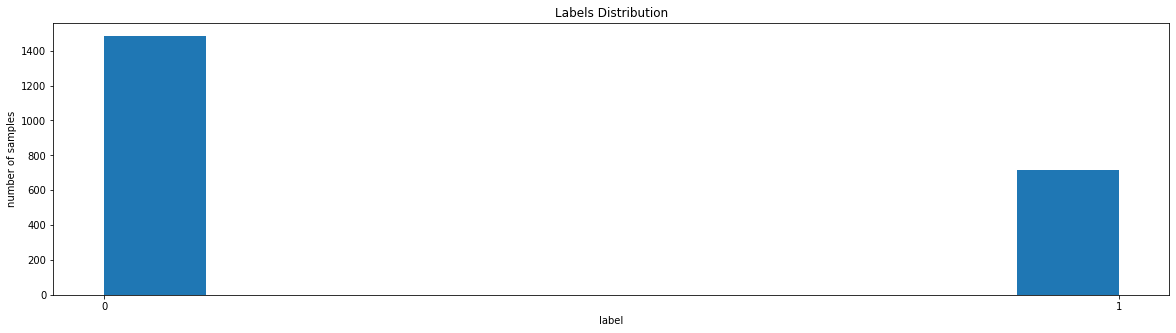

In [26]:
#plot labels
labels = df.label
plt.hist(labels)
plt.xlabel("label")
plt.ylabel("number of samples")
plt.title("Labels Distribution")
plt.xticks(np.arange(len(np.unique(labels))))

Tweet lengths description:                  0
count  2201.000000
mean     35.228987
std      21.252279
min       6.000000
25%      16.000000
50%      30.000000
75%      52.000000
max      94.000000

Tweet discarded data description:             0
count  2201.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0

Tweet discarded data ratios description:             0
count  2201.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0

Tweets exceeding 512 word limit: 2201 out of 2201 (100.00%)
Total data loss: 0 out of 77539 words (0.00% total, 0.00% average)


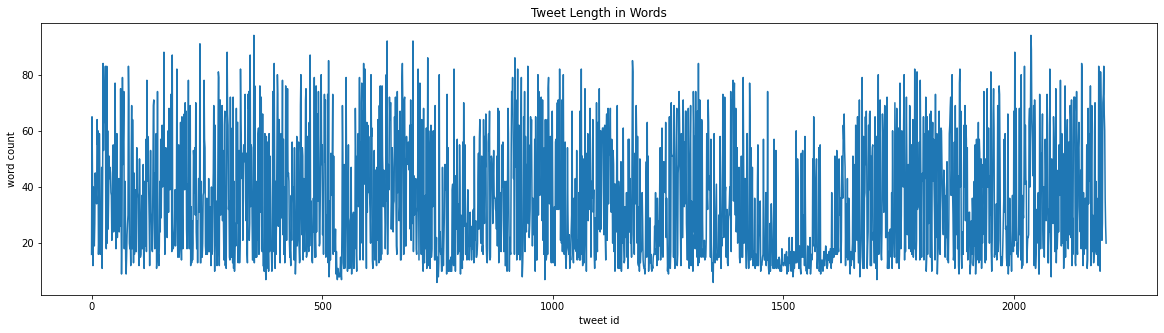

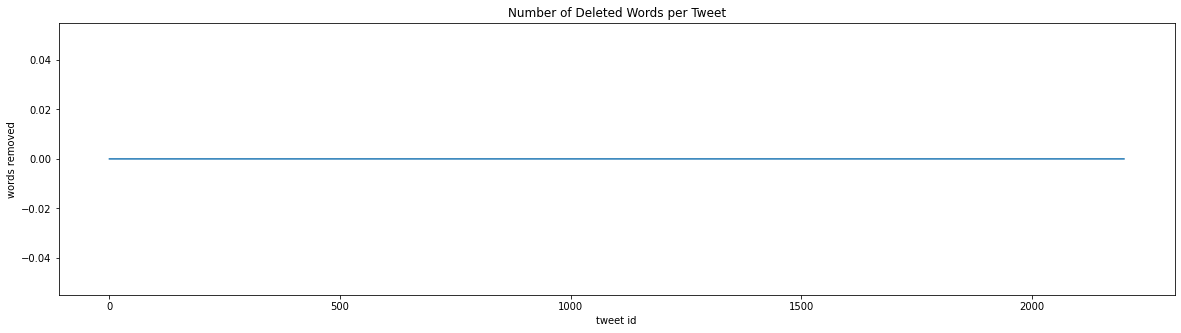

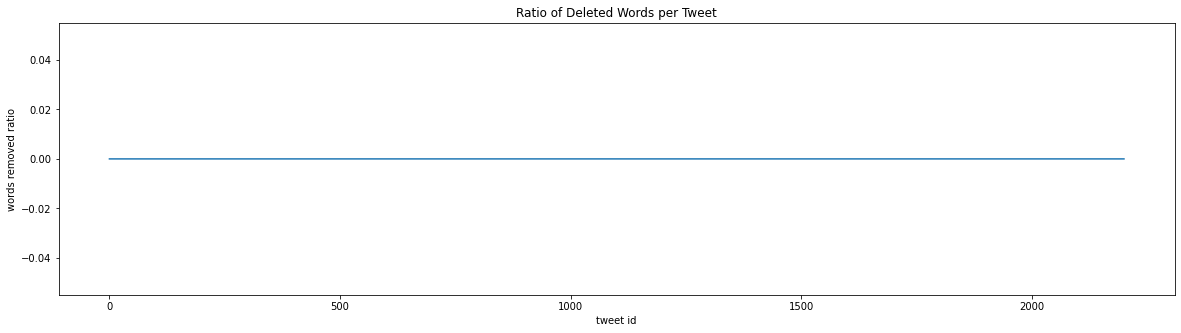

In [28]:
# plot article lengths and discarded data length
lengths = pd.DataFrame([len(x.split()) for x in df.text if isinstance(x, str)])
lost_data = pd.DataFrame([max(len(x.split())-512,0) for x in df.text if isinstance(x, str)])
lost_data_ratios = pd.DataFrame([max(len(x.split())-512,0)/float(len(x.split())) for x in df.text if isinstance(x, str)])

print("Tweet lengths description: %s\n" % (lengths.describe()))
lengths.plot(xlabel="tweet id", ylabel="word count", title="Tweet Length in Words", legend=None)
print("Tweet discarded data description: %s\n" % (lost_data.describe()))
lost_data.plot(xlabel="tweet id", ylabel="words removed", title="Number of Deleted Words per Tweet", legend=None)
print("Tweet discarded data ratios description: %s\n" % (lost_data_ratios.describe()))
lost_data_ratios.plot(xlabel="tweet id", ylabel="words removed ratio", title="Ratio of Deleted Words per Tweet", legend=None)

s1 = lost_data.sum()
s2 = lengths.sum()
ratio = float(s1) / float(s2)
s3 = (lengths <= 512).astype(int).sum(axis=0)
ratio2 = float(s3) / float(len(lengths))
print("Tweets exceeding 512 word limit: %d out of %d (%.2lf%%)" % (s3, len(lengths), ratio2*100))
print("Total data loss: %d out of %d words (%.2lf%% total, %.2lf%% average)" % (s1, s2, ratio*100, lost_data_ratios.mean()*100))

# Part 2: Tokenization and Input Formatting

In [35]:
start = time.time()

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()
###############################################################################
class BinaryGreekBERTModel(torch.nn.Module):

    def __init__(self, bert_model, dp):
        super(BinaryGreekBERTModel, self).__init__()
        self._bert_model = bert_model
        self._dp = torch.nn.Dropout(dp)
        self._output_linear = torch.nn.Linear(768, 1)

    def forward(self, text, text_len):
        attention_mask = pwF.create_mask_from_length(text_len, text.shape[1])
        return self._output_linear(self._dp(self._bert_model(text, attention_mask=attention_mask)[0][:, 0, :]))
###############################################################################

#from transformers import BertTokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
greekbert_model = AutoModel.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
binary_greekbert_model = BinaryGreekBERTModel(greekbert_model, dp=0)

working_set_df = df.head(2200)  # 2201 items don't split nicely, discard one

text_data = working_set_df.text
text_data.fillna('', inplace=True)

input_ids = []
attention_masks = []
for item in text_data:
    unaccented_string = strip_accents_and_lowercase(item)
    encoded_dict = tokenizer.encode_plus(unaccented_string,
                                         add_special_tokens=True,
                                         max_length=100,
                                         truncation=True,
                                         padding='max_length',
                                         #pad_to_max_length=True,
                                         return_attention_mask=True,
                                         return_tensors="pt")
    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(working_set_df.label.values)

print("Time elapsed: %.1lf seconds." % (time.time() - start))

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is try

Time elapsed: 4.7 seconds.


In [36]:
# split training and validation sets
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
validation_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
print("Training size: %s, Validation size: %s Test size: %s" % (train_size, validation_size, test_size))

batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, sampler=SequentialSampler(validation_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

Training size: 1760, Validation size: 220 Test size: 220


# Part 3: Training

In [37]:
start = time.time()

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "nlpaueb/bert-base-greek-uncased-v1",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

device = None
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.cuda()
else:
    device = torch.device("cpu")

############################################################
# Batch sizes: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Epochs: 2, 3, 4
############################################################

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

print("Time elapsed: %.2lf" % (time.time() - start))
!nvidia-smi

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Time elapsed: 21.27
Fri Nov  5 05:24:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    60W / 149W |   1039MiB / 11441MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## Training Loop

In [38]:
start = time.time()

def flat_accuracy(preds, labels):
    """Function to calculate the accuracy of our predictions vs labels"""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
###############################################################################

seed_val = 21
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('Epoch %s out of %s' % (epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            print('  Batch %s out  of  %s, Elapsed %.2lf seconds' % (step, len(train_dataloader), time.time() - t0))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        loss, logits = model(
            b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels,
            return_dict=False
        )

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.time() - t0

    print("  Average training loss: %.2lf" % (avg_train_loss))
    print("  Epoch %s training time %.2lf seconds" % (epoch_i, training_time))
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            loss, logits = model(
                b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,
                labels=b_labels,
                return_dict=False
            )
            
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = time.time() - t0

    print("  Accuracy: %.2lf" % (avg_val_accuracy))
    print("  Validation Loss: %2lf" % (avg_val_loss))
    print("  Validation time %.2lf seconds" % (validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("Training complete!")
print("Time elapsed: %.2lf seconds" % (time.time() - start))

Epoch 1 out of 4
Training...
  Batch 40 out  of  220, Elapsed 14.14 seconds
  Batch 80 out  of  220, Elapsed 27.84 seconds
  Batch 120 out  of  220, Elapsed 41.57 seconds
  Batch 160 out  of  220, Elapsed 55.52 seconds
  Batch 200 out  of  220, Elapsed 69.50 seconds
  Average training loss: 0.47
  Epoch 0 training time 76.36 seconds
Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.352907
  Validation time 3.01 seconds
Epoch 2 out of 4
Training...
  Batch 40 out  of  220, Elapsed 13.78 seconds
  Batch 80 out  of  220, Elapsed 27.54 seconds
  Batch 120 out  of  220, Elapsed 41.27 seconds
  Batch 160 out  of  220, Elapsed 55.28 seconds
  Batch 200 out  of  220, Elapsed 69.09 seconds
  Average training loss: 0.29
  Epoch 1 training time 75.82 seconds
Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.278729
  Validation time 2.95 seconds
Epoch 3 out of 4
Training...
  Batch 40 out  of  220, Elapsed 13.51 seconds
  Batch 80 out  of  220, Elapsed 27.03 seconds
  Batch 120

In [39]:
!nvidia-smi

Fri Nov  5 05:30:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    61W / 149W |   3230MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
##############################
# View training summary
##############################

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.47,0.35,0.83,76.36,3.01
2,0.29,0.28,0.90,75.82,2.95
3,0.21,0.31,0.93,74.28,2.97
4,0.12,0.38,0.92,73.88,2.98


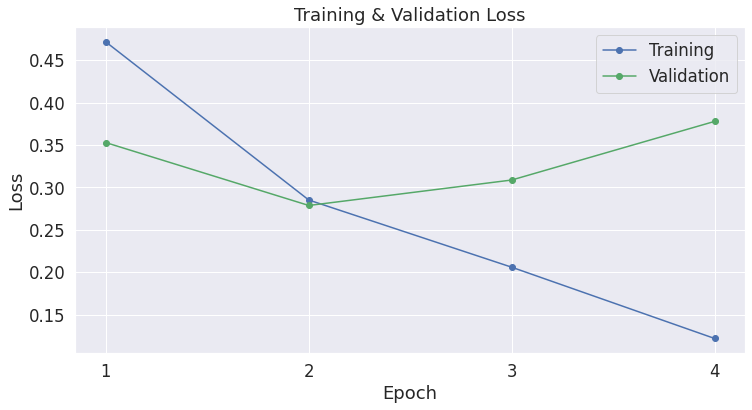

In [41]:
# If validation loss is increasing, it means we are overfitting!
# Plot training and validation loss
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [42]:
####################
# Save model to disk
####################
tstamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
output_dir = './greekbert_twitter_model_save/%s/' % (tstamp)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(optimizer.state_dict(), os.path.join(output_dir, 'training_args.bin'))

Saving model to ./greekbert_twitter_model_save/2021-11-05_053152/


In [44]:
!ls -lhatrR greekbert_twitter_model_save/

greekbert_twitter_model_save/:
total 12K
drwxr-xr-x 1 root root 4.0K Nov  5 05:31 ..
drwxr-xr-x 3 root root 4.0K Nov  5 05:31 .
drwxr-xr-x 2 root root 4.0K Nov  5 05:31 2021-11-05_053152

greekbert_twitter_model_save/2021-11-05_053152:
total 1.3G
drwxr-xr-x 3 root root 4.0K Nov  5 05:31 ..
-rw-r--r-- 1 root root  732 Nov  5 05:31 config.json
-rw-r--r-- 1 root root 431M Nov  5 05:31 pytorch_model.bin
-rw-r--r-- 1 root root  526 Nov  5 05:31 tokenizer_config.json
-rw-r--r-- 1 root root  112 Nov  5 05:31 special_tokens_map.json
-rw-r--r-- 1 root root 518K Nov  5 05:31 vocab.txt
-rw-r--r-- 1 root root 782K Nov  5 05:31 tokenizer.json
drwxr-xr-x 2 root root 4.0K Nov  5 05:31 .
-rw-r--r-- 1 root root 862M Nov  5 05:31 training_args.bin


# Part 4: Test

              precision    recall  f1-score   support

    not-fake       0.93      0.94      0.94       148
        fake       0.87      0.86      0.87        72

    accuracy                           0.91       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.91      0.91      0.91       220

Time elapsed: 3.29


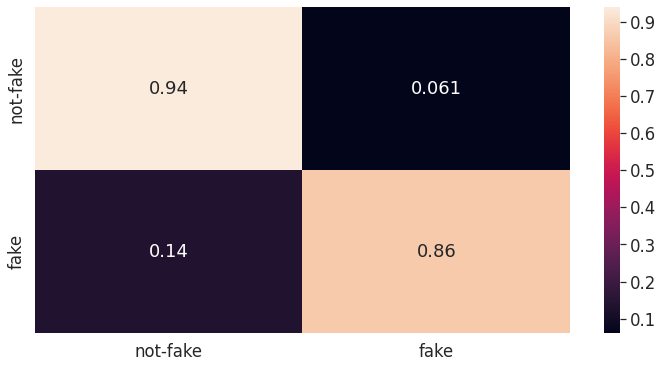

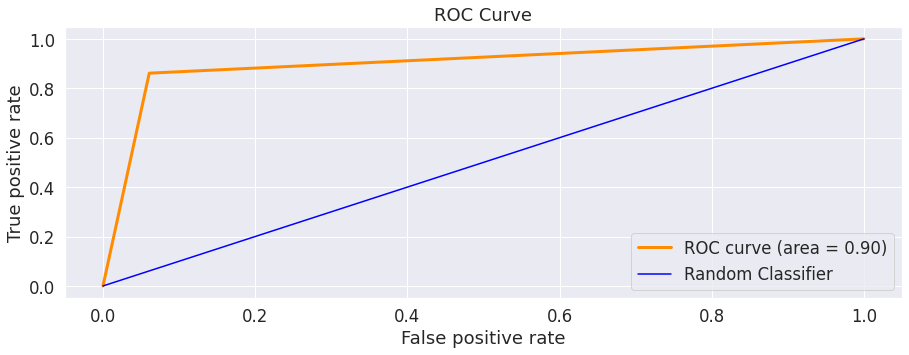

In [45]:
start = time.time()

epoch_loss = 0
epoch_acc = 0
predicted_labels = []
labels = []
model.eval()
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():
        loss, logits = model(
            b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=False
        )        
    epoch_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    epoch_acc += flat_accuracy(logits, label_ids)
    predicted_labels.extend(np.argmax(logits, axis=1).flatten())
    labels.extend(label_ids)
    test_loss = epoch_loss / len(test_dataloader)
    test_acc = epoch_acc / len(test_dataloader)
    test_labels = labels
    test_predictions = predicted_labels
    
print(sklearn.metrics.classification_report(test_labels, test_predictions, target_names=["not-fake", "fake"]))
cm = sklearn.metrics.confusion_matrix(test_labels, test_predictions, normalize='true')
df_cm = pd.DataFrame(cm, index=["not-fake", "fake"], columns=["not-fake", "fake"])
seaborn.heatmap(df_cm, annot=True)    
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, predicted_labels)
auc = sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(15, 5))
plt.plot(fpr, tpr, lw=3, color='darkorange', label="ROC curve (area = %.2lf)" % (auc))
plt.plot([0, 1], [0, 1], color="blue", label="Random Classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.legend()

print("Time elapsed: %.2lf" % (time.time() - start))